# WHITE BLOOD CELL CLASSIFICATION



Saving images.jpeg to images.jpeg


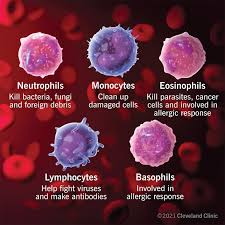

In [ ]:
from google.colab import files
from IPython.display import Image

uploaded = files.upload()
Image(filename='images.jpeg',width=500)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Data Summary**

This task aims to classify images of White Blood Cells into 9 subtypes. The specific types of WBCs to be classified are as follows: bands, basophils, blasts, eosinophils, lymphocytes, metamyelocytes, monocytes, myelocytes, and neutrophils.

The data has been provided to me and it contains two folders: WBC and classify-images. Images in the WBC folder have been used for training and testing the model. While the classify-images folder has been used to classify images into the 9 subtypes mentioned above.

1 WBC: This folder has 9 sub-folders, each containing labelled images of the sub-types of WBC. The images in these 9 sub-folders are to be used for training and testing the model.

2 classify-images: This folder has unlabelled images. It is to be used for classifying the images after the model has been trained and tested.

**Training Environment: Colab Notebook (free version)**

**Import the libraries**

In [ ]:
 #import the necessary libraries

import numpy as np
import cv2
import os
from os.path import exists
import shutil
import matplotlib.pyplot as plt
from collections import Counter

from keras.utils import to_categorical
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [ ]:
# mount the drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
 #path of the data directory in drive

DATA_DIR = '/content/drive/MyDrive/Desktop/ujwala ds project/taskwbc'

In [ ]:
# number of classes into which the classifications are to be made
num_classes = 9

# classes into which the classifications are to be made
classes = ['bands', 'basophils', 'blasts', 'eosinophils', 'lymphocytes', 'metamyelocytes', 'monocytes', 'myelocytes', 'neutrophils']


Create train and test folders in the base directory

There are two folders in the base directory:

wbc: it has 9 sub-folders, each containing labelled images of the sub-types of wbc.

classify-images: it has unlabelled images. It is to be used for testing.

Two more folders using the labelled images of the folder wbc in the base directory are created. One folder is named as train and the other as test.

train: 80% of the labelled images of folder wbc are copied into the train folder.

test: the remaining labelled images are copied into the test folder.

The train folder will be used for model training.

The test folder will be used for model testing and evaluation. This is because the folder classify-images has unlabelled images and it is difficult to create confusion matrix using it.

In [ ]:
# create two folders in the DATA directory: train and test

train_folder_exists = exists(DATA_DIR + '/train')

# assuming if train folder exists then test folder also exists because both are being created simultaneously

if train_folder_exists:

    # remove train and test directories from the base folder else if this code is run twice then
    # data will be augmented twice and we will get an error on the dimensions while model training

    shutil.rmtree(DATA_DIR + '/train')
    shutil.rmtree(DATA_DIR + '/test')



for i in classes:

    os.makedirs(DATA_DIR + '/train/' + i)       # create the train folder and the sub-folders for the sub-types inside it

    os.makedirs(DATA_DIR + '/test/' + i)        # create the test folder and the sub-folders for the sub-types inside it

    source = DATA_DIR + '/wbc/' + i             # path to the sub-folders inside the folder wbc

    allFileNames = os.listdir(source)           # names of all the labelled images inside the sub-folders of the folder wbc

    np.random.shuffle(allFileNames)             # randomly shuffling before splitting into train and test

    test_ratio = 0.20                           # setting the test ratio = 20%

    # splitting the file-names into train and test parts

    train_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                      [int(len(allFileNames)* (1 - test_ratio))])

    # converting the file-names array into list of paths of their source

    train_FileNames = [source + '/' + name for name in train_FileNames.tolist()]
    test_FileNames = [source + '/' + name for name in test_FileNames.tolist()]

    # using shutil to copy the labelled images from their source to their train and test destination folders

    for name in train_FileNames:
        shutil.copy(name, DATA_DIR +'/train/' + i)

    for name in test_FileNames:
        shutil.copy(name, DATA_DIR +'/test/' + i)


Create the variables X and y

In [ ]:
# method to get the images as independent variable X and their labels as the dependent variable y

def get_data(folder):

    X = []
    y = []

    # if the image files in the folder wbc are not empty then read the files
    # and convert the images as numpy arrays
    # append the image numpy arrays to the independent variable X
    # and append their labels to y

    for wbc_type in os.listdir(folder):

        if not wbc_type.startswith('.'):

            for image_filename in os.listdir(folder + '/' + wbc_type):
                img_file = cv2.imread(folder + '/' + wbc_type + '/' + image_filename)

                if img_file is not None:
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(wbc_type)

    # create numpy arrays of X and y

    X = np.asarray(X)
    y = np.asarray(y)

    return X,y

In [ ]:
# call the get_data method using the path to the train and test folders as arguments
# to get the variables X_train, y_train, X_test and y_test

X_train, y_train = get_data(DATA_DIR + '/train')
X_test, y_test = get_data(DATA_DIR + '/test')


**Normalize the input**

In [ ]:
# get all dimensions of the X
n_samples, height, width, n_channels = [X_train.shape[index] for index in range(4)]
print(f"Shape of X_train: {X_train.shape}")

n_samples, height, width, n_channels = [X_test.shape[index] for index in range(4)]
print(f"Shape of X_test: {X_test.shape}")


Shape of X_train: (421, 256, 256, 3)
Shape of X_test: (107, 256, 256, 3)


Total Images = 421  in X_train having width = 256 and height = 256 and channels = 3
Total Images = 107 in X_test having width = 256 and height = 256 and channels = 3

In [ ]:
# image has scale [0, 255], hence multiply by the scaling factor 1./255.
# to rescale to pixels to range [0, 1]

X_train = X_train * 1./255.
X_test = X_test * 1./255.

**Check the balance of the train dataset**

In [ ]:
# summarize the class distribution in the train dataset

counter = Counter(y_train)
print(counter)

Counter({'neutrophils': 168, 'lymphocytes': 152, 'monocytes': 24, 'bands': 21, 'eosinophils': 20, 'metamyelocytes': 20, 'myelocytes': 7, 'basophils': 6, 'blasts': 3})


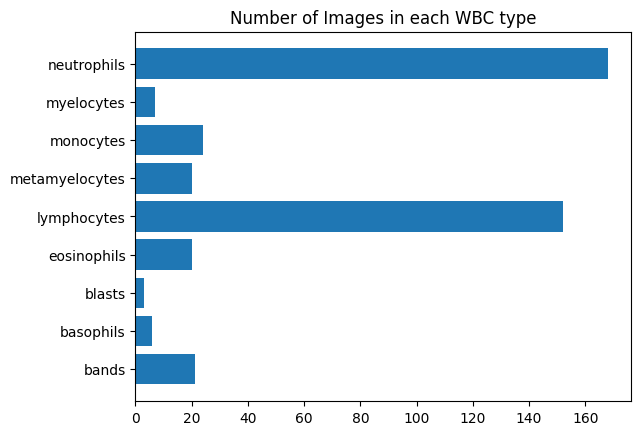

In [ ]:
# plot the number of images in each sub-folder of the train dataset

y_train_unique_counts = np.unique(y_train, return_counts=True)

plt.title('Number of Images in each WBC type')
plt.barh(y_train_unique_counts[0], y_train_unique_counts[1])
plt.show()

1.This is an imbalanced dataset.
2.neutrophils is the majority class with 168 image samples.
3.blasts has the least number of samples: only 3 samples.
4.myelocytes and basophils have only 7 and 6 samples

Hence, there is a need to treat the imbalance of the train dataset.

There are a two of ways of data imbalance:

1.Under-sampling the over-represented class.

2.Over-sampling the under-represented class.

SMOTE (Synthetic Minority Oversampling Technique).

If SMOTE is applied before augmentation on the given dataset, there is a restriction.

The class blasts has only 3 samples in the train dataset. Since, SMOTE works using the KNN algorithm, each image in the class blast has only 2 neighbours. This will create similar types of images in the classes that have very few images.

Therefore, applying SMOTE after image augmentation will create more variations.

**Augment the train dataset**

The number of new variations created by augmentation is limited by the computing resources (System RAM =4.00  GB) provided in Colab notebook.

In [ ]:
# getting the image arrays associated with each class type in the train dataset

basophils_samples = X_train[np.where(y_train == 'basophils')]
bands_samples = X_train[np.where(y_train == 'bands')]
blasts_samples = X_train[np.where(y_train == 'blasts')]
eosinophils_samples = X_train[np.where(y_train == 'eosinophils')]
lymphocytes_samples = X_train[np.where(y_train == 'lymphocytes')]
monocytes_samples = X_train[np.where(y_train == 'monocytes')]
metamyelocytes_samples = X_train[np.where(y_train == 'metamyelocytes')]
myelocytes_samples = X_train[np.where(y_train == 'myelocytes')]
neutrophils_samples = X_train[np.where(y_train == 'neutrophils')]


In [ ]:
# using ImageDataGenerator to define new variations

datagen = ImageDataGenerator(
    rotation_range=20,
    fill_mode='constant',
    height_shift_range=0.1,
    width_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.2
)

In [ ]:
# saving the new variations to their respective folders in the train dataset

basophils_generator = datagen.flow(
        basophils_samples,
        y_train[np.where(y_train == 'basophils')],
        save_to_dir = DATA_DIR + '/train/basophils',
        batch_size=1)

bands_generator = datagen.flow(
        bands_samples,
        y_train[np.where(y_train == 'bands')],
        save_to_dir = DATA_DIR + '/train/bands',
        batch_size=1)

blasts_generator = datagen.flow(
        blasts_samples,
        y_train[np.where(y_train == 'blasts')],
        save_to_dir = DATA_DIR + '/train/blasts',
        batch_size=1)

eosinophils_generator = datagen.flow(
        eosinophils_samples,
        y_train[np.where(y_train == 'eosinophils')],
        save_to_dir = DATA_DIR + '/train/eosinophils',
        batch_size=1)

lymphocytes_generator = datagen.flow(
        lymphocytes_samples,
        y_train[np.where(y_train == 'lymphocytes')],
        save_to_dir = DATA_DIR + '/train/lymphocytes',
        batch_size=1)

monocytes_generator = datagen.flow(
        monocytes_samples,
        y_train[np.where(y_train == 'monocytes')],
        save_to_dir = DATA_DIR + '/train/monocytes',
        batch_size=1)

metamyelocytes_generator = datagen.flow(
        metamyelocytes_samples,
        y_train[np.where(y_train == 'metamyelocytes')],
        save_to_dir = DATA_DIR + '/train/metamyelocytes',
        batch_size=1)

myelocytes_generator = datagen.flow(
        myelocytes_samples,
        y_train[np.where(y_train == 'myelocytes')],
        save_to_dir = DATA_DIR + '/train/myelocytes',
        batch_size=1)

neutrophils_generator = datagen.flow(
        neutrophils_samples,
        y_train[np.where(y_train == 'neutrophils')],
        save_to_dir = DATA_DIR + '/train/neutrophils',
        batch_size=1)


 aim is used to create total of 225 images of the majority class which is neutrophils
 neutrophils has total 168 images before augmentation
hence, after augmentation, neutrophils will have total
168 + 82 = 250 images


In [ ]:
size_of_majority_class = 168
num_of_augmentations = 225 - size_of_majority_class

In [ ]:
# creating new variations in the train dataset

for i in range(num_of_augmentations):
    next(basophils_generator)
    next(bands_generator)
    next(blasts_generator)
    next(eosinophils_generator)
    next(lymphocytes_generator)
    next(monocytes_generator)
    next(metamyelocytes_generator)
    next(myelocytes_generator)
    next(neutrophils_generator)

In [ ]:
datagen_simple = ImageDataGenerator()

In [ ]:
basophils_test_samples = X_test[np.where(y_test == 'basophils')]
bands_test_samples = X_test[np.where(y_test == 'bands')]
blasts_test_samples = X_test[np.where(y_test == 'blasts')]
eosinophils_test_samples = X_test[np.where(y_test == 'eosinophils')]
lymphocytes_test_samples = X_test[np.where(y_test == 'lymphocytes')]
monocytes_test_samples = X_test[np.where(y_test == 'monocytes')]
metamyelocytes_test_samples = X_test[np.where(y_test == 'metamyelocytes')]
myelocytes_test_samples = X_test[np.where(y_test == 'myelocytes')]
neutrophils_test_samples = X_test[np.where(y_test == 'neutrophils')]


In [ ]:
basophils_test_generator = datagen_simple.flow(
        basophils_test_samples,
        y_test[np.where(y_test == 'basophils')],
        save_to_dir = DATA_DIR + '/test/basophils',
        batch_size=1)

bands_test_generator = datagen_simple.flow(
        bands_test_samples,
        y_test[np.where(y_test == 'bands')],
        save_to_dir = DATA_DIR + '/test/bands',
        batch_size=1)

blasts_test_generator = datagen_simple.flow(
        blasts_test_samples,
        y_test[np.where(y_test == 'blasts')],
        save_to_dir = DATA_DIR + '/test/blasts',
        batch_size=1)

eosinophils_test_generator = datagen_simple.flow(
        eosinophils_test_samples,
        y_test[np.where(y_test == 'eosinophils')],
        save_to_dir = DATA_DIR + '/test/eosinophils',
        batch_size=1)

lymphocytes_test_generator = datagen_simple.flow(
        lymphocytes_test_samples,
        y_test[np.where(y_test == 'lymphocytes')],
        save_to_dir = DATA_DIR + '/test/lymphocytes',
        batch_size=1)

monocytes_test_generator = datagen_simple.flow(
        monocytes_test_samples,
        y_test[np.where(y_test == 'monocytes')],
        save_to_dir = DATA_DIR + '/test/monocytes',
        batch_size=1)

metamyelocytes_test_generator = datagen_simple.flow(
        metamyelocytes_test_samples,
        y_test[np.where(y_test == 'metamyelocytes')],
        save_to_dir = DATA_DIR + '/test/metamyelocytes',
        batch_size=1)

myelocytes_test_generator = datagen_simple.flow(
        myelocytes_test_samples,
        y_test[np.where(y_test == 'myelocytes')],
        save_to_dir = DATA_DIR + '/test/myelocytes',
        batch_size=1)

neutrophils_test_generator = datagen_simple.flow(
        neutrophils_test_samples,
        y_test[np.where(y_test == 'neutrophils')],
        save_to_dir = DATA_DIR + '/test/neutrophils',
        batch_size=1)

In [ ]:
for i in range(len(basophils_test_samples)):
    next(basophils_test_generator)

for i in range(len(bands_test_samples)):
    next(bands_test_generator)

for i in range(len(blasts_test_samples)):
    next(blasts_test_generator)

for i in range(len(eosinophils_test_samples)):
    next(eosinophils_test_generator)

for i in range(len(lymphocytes_test_samples)):
    next(lymphocytes_test_generator)

for i in range(len(monocytes_test_samples)):
    next(monocytes_test_generator)

for i in range(len(metamyelocytes_test_samples)):
    next(metamyelocytes_test_generator)

for i in range(len(myelocytes_test_samples)):
    next(myelocytes_test_generator)

for i in range(len(neutrophils_test_samples)):
    next(neutrophils_test_generator)

Load the augmented training dataset

In [ ]:
# using the get_data method defined earlier to load the augmented training data

X_train, y_train = get_data(DATA_DIR + '/train')
X_test, y_test = get_data(DATA_DIR + '/test')

In [ ]:
# summarize the new class distribution in the augmented train dataset

counter = Counter(y_train)
print(counter)


Counter({'neutrophils': 225, 'lymphocytes': 209, 'monocytes': 81, 'bands': 78, 'eosinophils': 77, 'metamyelocytes': 77, 'myelocytes': 64, 'basophils': 63, 'blasts': 60})


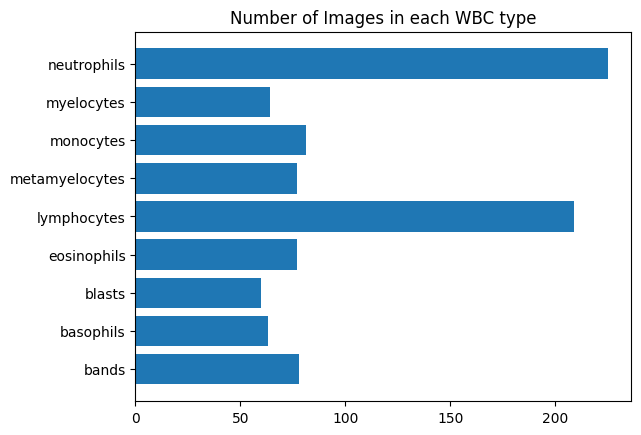

In [ ]:
# visualize the new class distribution the augmented train dataset

y_train_unique_counts = np.unique(y_train, return_counts=True)

plt.title('Number of Images in each WBC type')
plt.barh(y_train_unique_counts[0], y_train_unique_counts[1])
plt.show()

In [ ]:
# number of classes into which the classifications are to be made
num_classes = 9

# classes into which the classifications are to be made
classes = ['bands', 'basophils', 'blasts', 'eosinophils', 'lymphocytes', 'metamyelocytes', 'monocytes', 'myelocytes', 'neutrophils']



In [ ]:
!pip install imblearn


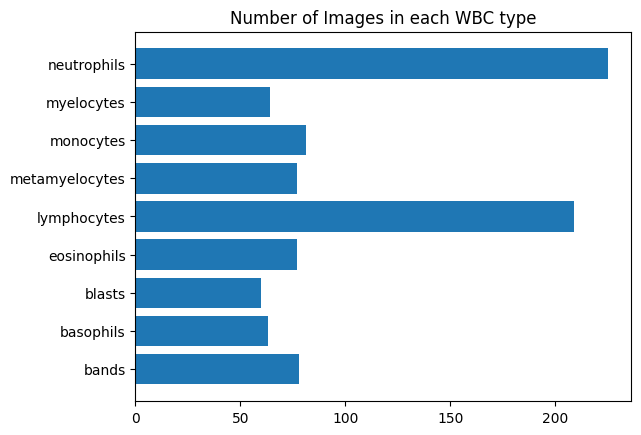

In [ ]:
# plot the number of images in each sub-folder of the train dataset

y_train_unique_counts = np.unique(y_train, return_counts=True)

plt.title('Number of Images in each WBC type')
plt.barh(y_train_unique_counts[0], y_train_unique_counts[1])
plt.show()


**SMOTE to treat the imbalance in the dataset**

In [ ]:
# get all the dimensions of X_train

n_samples, height, width, n_channels = [X_train.shape[index] for index in range(4)]
print(f"Shape of X_train before reshape: {X_train.shape}")


Shape of X_train before reshape: (934, 256, 256, 3)


In [ ]:
# reshape X because SMOTE accepts only (n_samples, n_channels*height*weight) type data

X_train_reshaped = X_train.reshape(n_samples, n_channels*height*width)
print(f"Shape of X_train after reshape: {X_train_reshaped.shape}")


Shape of X_train after reshape: (934, 196608)


In [ ]:
# initialize the SMOTE model
from imblearn.over_sampling import SMOTE
smote = SMOTE(k_neighbors=5, random_state=62)


In [ ]:
# perform re-sampling on modified X given y of the train data

X_smote, y_smote = smote.fit_resample(X_train_reshaped, y_train)




In [ ]:
# number of images before and after applying SMOTE

print(f'Before re-sampling, the number of images: {len(X_train):2}')
print(f'After re-sampling, the number of images: {len(X_smote):2}')


Before re-sampling, the number of images: 934
After re-sampling, the number of images: 2025


The number of samples in the train dataset has increased from 1158 to 2250 after applying SMOTE

In [ ]:
# summarize the new class distribution after applying SMOTE on the train data

counter = Counter(y_smote)
print(counter)

Counter({'bands': 225, 'basophils': 225, 'blasts': 225, 'eosinophils': 225, 'lymphocytes': 225, 'metamyelocytes': 225, 'monocytes': 225, 'myelocytes': 225, 'neutrophils': 225})


(array(['bands', 'basophils', 'blasts', 'eosinophils', 'lymphocytes',
       'metamyelocytes', 'monocytes', 'myelocytes', 'neutrophils'],
      dtype='<U14'), array([225, 225, 225, 225, 225, 225, 225, 225, 225]))


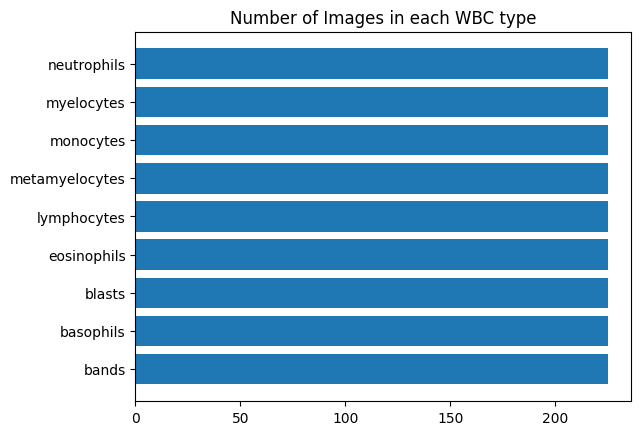

In [ ]:

# view the resulting balanced data (modified distribution) after applying SMOTE

y_smote_unique_counts = np.unique(y_smote, return_counts=True)
print(y_smote_unique_counts)

plt.title('Number of Images in each WBC type')
plt.barh(y_smote_unique_counts[0], y_smote_unique_counts[1])
plt.show()

Each class in the train dataset has 250 samples after applying SMOTE
This removes the imbalance in the train dataset

In [ ]:
# assign the values of X_smote and y_smote to X_train and y_train respectively

X_train, y_train = X_smote, y_smote



In [ ]:
# re-shape the dimension of X_train that was changed to apply SMOTE

n_samples, height, width, n_channels = 225*9, 256, 256, 3

X_train = X_train.reshape(n_samples, height, width, n_channels)


In [ ]:
# get all the dimensions of X_train

n_samples, height, width, n_channels = [X_train.shape[index] for index in range(4)]
print(f"Shape of X_train before reshape: {X_train.shape}")


Shape of X_train before reshape: (2025, 256, 256, 3)


Shape of X_train has been restored for training the model



# One-hot encoding of the labels

In [ ]:

# Convert the labels in y_train using one-hot encoding

encoder = LabelEncoder()
encoder.fit(y_train)
encoded_y_train = encoder.transform(y_train)
encoded_y_test = encoder.transform(y_test)

y_train = np_utils.to_categorical(encoded_y_train)
y_test = np_utils.to_categorical(encoded_y_test)


# Model: **VGG16**

In [ ]:
# define the variables to be used in the model

num_classes = 9

epochs = 10
batch_size = 32

In [ ]:
# define the VGG16 model
from keras.layers import Input, Flatten, Dense
from keras.models import Model
from keras.applications import VGG16
from keras import applications

base_model = applications.VGG16(include_top=False, weights='imagenet')
input = Input(shape=(256, 256, 3), name = 'image_input')
vgg_output = base_model(input)

top_model = Flatten()(vgg_output)
top_model = Dense(64, activation='relu')(top_model)
predictions = Dense(num_classes, activation='softmax', name='prediction_layer')(top_model)

model = Model(inputs=input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers

layers = base_model.layers[:-2]
for layer in layers:
    layer.trainable = False

58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
# compile the model (should be done after setting layers to non-trainable)

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])



Accuracy is used as a metric for model evaluation because it is more important that the model classifies each image correctly rather than penalizing the False-Positives (Precision) or the False-Negatives (Recall) or penalizing both (F1).

In [ ]:

# model summary

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 64)                2097216   
                                                                 
 prediction_layer (Dense)    (None, 9)                 585       
                                                                 
Total params: 16,812,489
Trainable params: 4,457,609
Non-trainable params: 12,354,880
_________________________________________________________________


In [ ]:
# fit the model on train data

model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, shuffle=True, verbose=1)


Epoch 1/10
51/51 [==============================] - 38s 430ms/step - loss: 23.3976 - accuracy: 0.4451 - val_loss: 5.0369 - val_accuracy: 0.0815
Epoch 2/10
51/51 [==============================] - 10s 198ms/step - loss: 2.2147 - accuracy: 0.5648 - val_loss: 11.8956 - val_accuracy: 0.0148
Epoch 3/10
51/51 [==============================] - 10s 201ms/step - loss: 1.4355 - accuracy: 0.6840 - val_loss: 9.1458 - val_accuracy: 0.1432
Epoch 4/10
51/51 [==============================] - 10s 203ms/step - loss: 1.1054 - accuracy: 0.7432 - val_loss: 12.6531 - val_accuracy: 0.1383
Epoch 5/10
51/51 [==============================] - 10s 206ms/step - loss: 0.9640 - accuracy: 0.8019 - val_loss: 8.4579 - val_accuracy: 0.1827
Epoch 6/10
51/51 [==============================] - 10s 200ms/step - loss: 0.7492 - accuracy: 0.8481 - val_loss: 11.9267 - val_accuracy: 0.1654
Epoch 7/10
51/51 [==============================] - 11s 213ms/step - loss: 0.7096 - accuracy: 0.8759 - val_loss: 21.1302 - val_accuracy: 0

In [ ]:
# save the weights of the model

model.save_weights('vgg_top.h5')


In [ ]:
# load the weights of the moodel

model.load_weights('vgg_top.h5')

# Prediction on the test dataset that was created using 20% images of the wbc folder

In [ ]:
# predictions on the test dataset

y_pred = model.predict(X_test)

print(y_pred)

7/7 [==============================] - 5s 829ms/step
[[2.42299325e-06 9.64013195e-15 7.95954185e-24 ... 4.39256098e-08
  3.24523634e-18 9.99600351e-01]
 [5.73309778e-26 0.00000000e+00 3.12141784e-36 ... 0.00000000e+00
  0.00000000e+00 1.00000000e+00]
 [1.50778535e-16 1.41556121e-27 1.36206223e-15 ... 5.46693280e-21
  1.11242800e-10 9.84025061e-01]
 ...
 [2.03490194e-18 0.00000000e+00 1.29324406e-20 ... 0.00000000e+00
  6.61139207e-37 1.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.00000000e+00]
 [3.45267143e-28 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.00000000e+00]]


In [ ]:
# rounding the elements of the y_pred array to the nearest integer using np.rint

y_pred = np.rint(y_pred)

print(y_pred)

[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [ ]:
# print the accuracy obtained on the test data
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

print(accuracy_score(y_test, y_pred))


0.7476635514018691


Accurancy is 74%

In [ ]:
# the confusion matrix

y_pred_unencoded = np.argmax(y_pred, axis=1)
y_test_unencoded = np.argmax(y_test, axis=1)

print(confusion_matrix(y_test_unencoded, y_pred_unencoded))


[[ 0  0  0  0  0  4  0  0  8]
 [ 0  2  0  0  0  2  0  0  0]
 [ 0  0  0  0  1  0  0  0  1]
 [ 0  0  0  0  2  2  2  0  4]
 [ 0  0  0  0 70  2  0  0  4]
 [ 0  0  0  0  1  3  2  0  4]
 [ 0  0  0  0  1  4  7  0  0]
 [ 0  0  0  0  0  0  2  0  2]
 [ 0  0  0  0  0  4  2  0 78]]


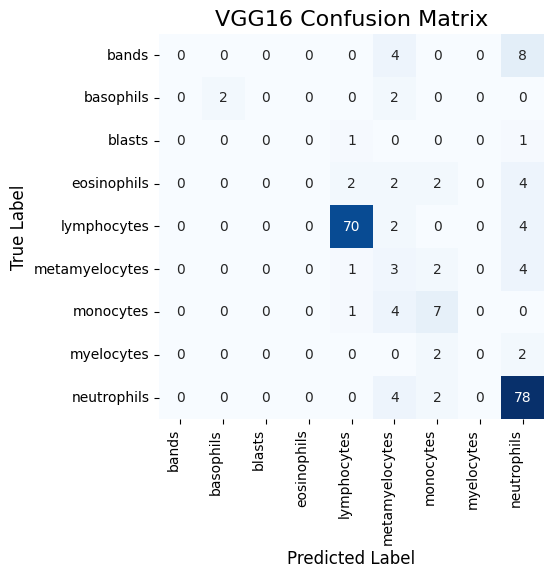

In [ ]:
# confusion matrix visualization using heatplot
import seaborn as sns

def plot_heatmap(y_true, y_pred, class_names, ax, title):

    cm = confusion_matrix(y_true, y_pred)

    sns.heatmap(
        cm,
        annot=True,
        square=True,
        xticklabels=class_names,
        yticklabels=class_names,
        fmt='d',
        cmap=plt.cm.Blues,
        cbar=False,
    )

    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

# Get the names of the ten classes
class_names = classes

fig = plt.figure(figsize = (5, 5))
ax = fig.gca()
plot_heatmap(y_test_unencoded, y_pred_unencoded, class_names, ax, title="VGG16 Confusion Matrix")
plt.show()

# Prediction on the classify-images dataset

In [ ]:
# define get_data_classify_images to load the images in the classify-images folder

def get_data_classify_images(folder):

    X = []
    y = []

    for image_filename in os.listdir(folder):
        img_file = cv2.imread(folder + '/' + image_filename)

        if img_file is not None:
            img_arr = np.asarray(img_file)
            X.append(img_arr)
            y.append(image_filename)

    X = np.asarray(X)
    y = np.asarray(y)

    return X, y

In [ ]:
# call the get_data_classify_images method using the path of classify-images folder as the argument

X_classify_images, classify_images_filenames = get_data_classify_images(DATA_DIR + '/classify-image')


In [ ]:
# load weights of the model

model.load_weights('vgg_top.h5')



In [ ]:
# prediction on the classify-images data

y_pred_classify_images = model.predict(X_classify_images)

2/2 [==============================] - 5s 5s/step


In [ ]:
# rounding the elements of the y_pred array to the nearest integer using np.rint

y_pred_classify_images = np.rint(y_pred_classify_images)

print('Prediction on the classify-images data')
print()

print(y_pred_classify_images)

Prediction on the classify-images data

[[0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [ ]:
import pandas as pd
IMAGES = pd.DataFrame(data = y_pred_classify_images, index = classify_images_filenames, columns = classes)


In [ ]:
IMAGES

,bands,basophils,blasts,eosinophils,lymphocytes,metamyelocytes,monocytes,myelocytes,neutrophils
1.jpg,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
22.jpg,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
12.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
13.jpg,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
40.jpg,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
41.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
14.jpg,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
23.jpg,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
37.jpg,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


import numpy as np
from google.colab import autoviz
df_3826845876805406256 = autoviz.get_registered_df('df_3826845876805406256')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_3826845876805406256, *['basophils'], **{})
chart

import numpy as np
from google.colab import autoviz
df_2496741079713932333 = autoviz.get_registered_df('df_2496741079713932333')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_2496741079713932333, *['eosinophils'], **{})
chart

import numpy as np
from google.colab import autoviz
df_3793705293120712446 = autoviz.get_registered_df('df_3793705293120712446')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_3793705293120712446, *['lymphocytes'], **{})
chart

import numpy as np
from google.colab import autoviz
df_1286319128928256728 = autoviz.get_registered_df('df_1286319128928256728')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_1286319128928256728, *['metamyelocytes'], **{})
chart

import numpy as np
from google.colab import autoviz
df_1896545270888963934 = autoviz.get_registered_df('df_1896545270888963934')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_1896545270888963934, *['basophils'], **{})
chart

import numpy as np
from google.colab import autoviz
df_3078357364710950026 = autoviz.get_registered_df('df_3078357364710950026')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_3078357364710950026, *['eosinophils'], **{})
chart

import numpy as np
from google.colab import autoviz
df_8585026638830413640 = autoviz.get_registered_df('df_8585026638830413640')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_8585026638830413640, *['lymphocytes'], **{})
chart

import numpy as np
from google.colab import autoviz
df_7448493052825423579 = autoviz.get_registered_df('df_7448493052825423579')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_7448493052825423579, *['metamyelocytes'], **{})
chart

import numpy as np
from google.colab import autoviz
df_7219938131260691178 = autoviz.get_registered_df('df_7219938131260691178')

def scatter_plots(df, colname_pairs, scatter_plot_size=2.5, size=8, alpha=.6):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * scatter_plot_size, scatter_plot_size))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    ax.scatter(df[x_colname], df[y_colname], s=size, alpha=alpha)
    plt.xlabel(x_colname)
    plt.ylabel(y_colname)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(df_7219938131260691178, *[[['basophils', 'eosinophils'], ['eosinophils', 'lymphocytes'], ['lymphocytes', 'metamyelocytes'], ['metamyelocytes', 'monocytes']]], **{})
chart

VGG16 model has been trained.It is achieving around 73% accuracy on the test data.So, More work has to be done to improve it.

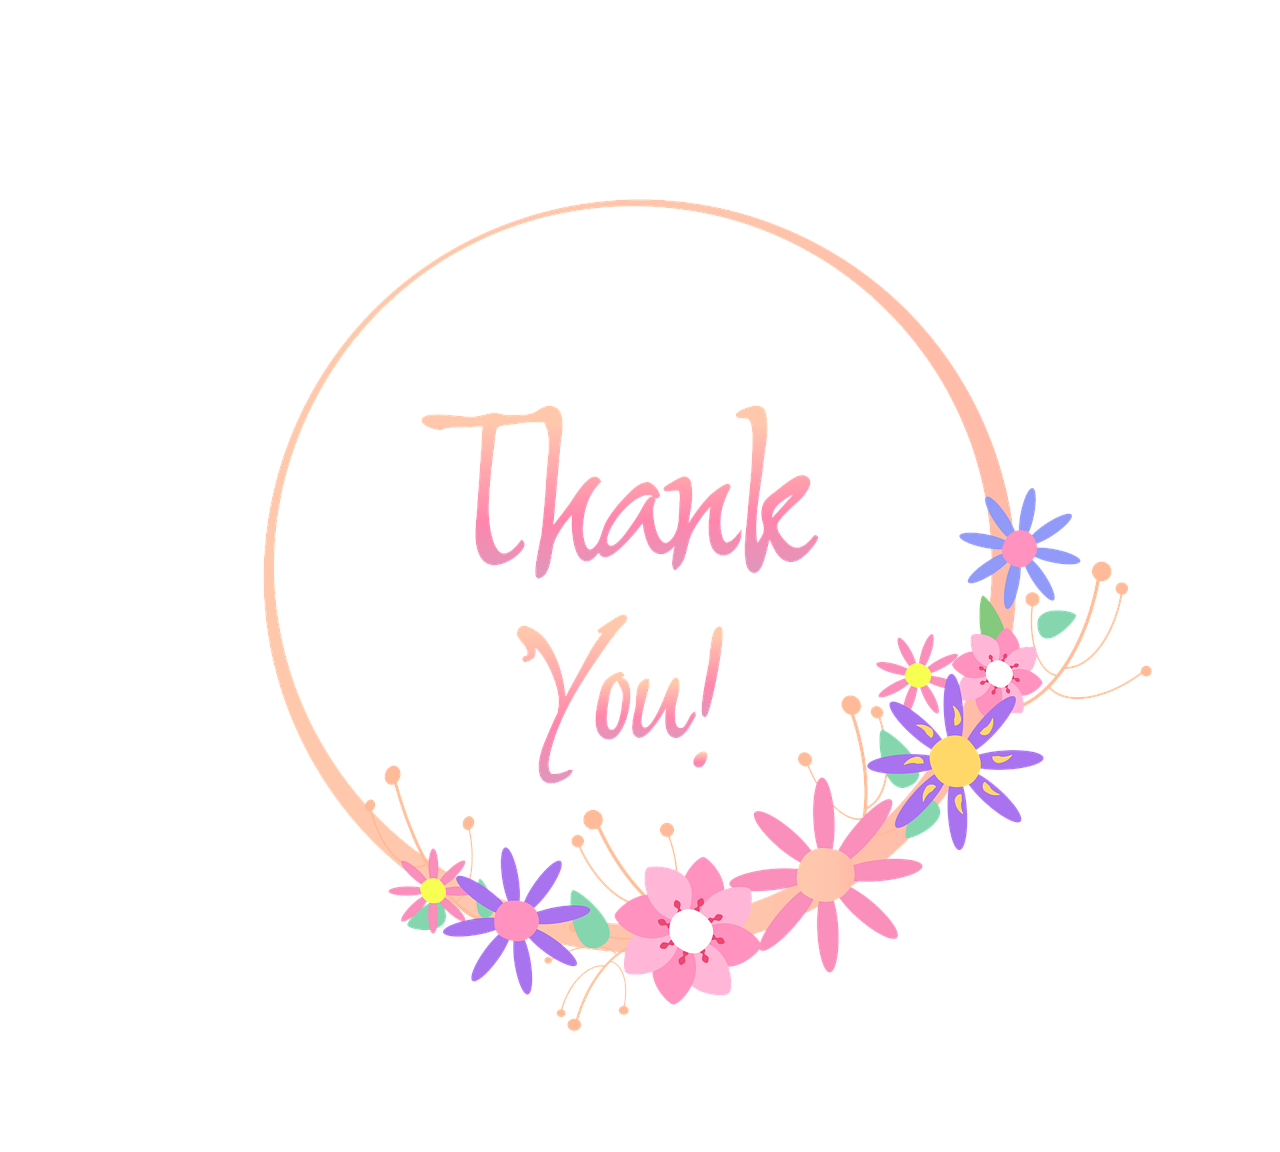

In [ ]:
from google.colab import files
from IPython.display import Image

uploaded = files.upload
Image(filename='thank-you-g10d0e3d99_1280.png',width=500)